In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from tqdm.notebook import trange

In [2]:
class VAE(nn.Module):
    def __init__(self, x_shape, z_dim, hidden_dim=500):
        super().__init__()
        
        self.x_shape = x_shape
        self.x_dim = np.prod(x_shape)
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(self.x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, z_dim)
        )
        self.sigma_net = nn.Sequential(
            nn.Linear(hidden_dim, z_dim),
            nn.Softplus()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.x_dim),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        x = x.view(len(x), self.x_dim)
        h = self.encoder(x)
        z_mu = self.mu_net(h)
        z_sigma = self.sigma_net(h)
        return dist.Normal(z_mu, z_sigma)

    def decode(self, z):
        return self.decoder(z).view(len(z), *self.x_shape)


In [3]:
def compute_elbo(x, x_reconst, z_posterior, z_prior):
    log_likelihood = (x*torch.log(x_reconst + 1e-6) + (1-x)*torch.log(1 - x_reconst + 1e-6)).sum((1, 2, 3))
    kl = dist.kl_divergence(z_dist, z_prior).sum(1)
    return (log_likelihood - kl).mean()

In [14]:
z_dim = 2
z_prior = dist.Normal(0, 1)

n_epoch = 10
batch_size = 200
lr = 1e-3

device = 0

dataset = datasets.MNIST('.', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
x_shape = (1, 28, 28)
vae = VAE(x_shape=x_shape, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [8]:
x_examples = next(iter(loader))[0].to(device)
epoch_x_reconst_examples = []
losses = []

for epoch_i in trange(n_epoch):
    epoch_x_reconst_examples.append(vae.decode(vae.encode(x_examples).rsample()))
    
    for x, _ in loader:
        x = x.to(device)
        
        z_dist = vae.encode(x)
        z = z_dist.rsample()
        x_reconst = vae.decode(z)
        
        elbo = compute_elbo(x, x_reconst, z_dist, z_prior)
        loss = -elbo
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

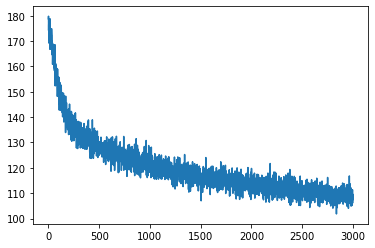

In [9]:
plt.plot(range(len(losses)), losses)

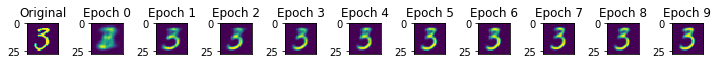

In [16]:
idx = 2
epochs = range(n_epoch)

fig, axes = plt.subplots(1, len(epochs)+1, figsize=(10, 2))
imgs = [x_examples[idx]] + [epoch_x_reconst_examples[epoch][idx] for epoch in epochs]
titles = ['Original'] + [f'Epoch {epoch}' for epoch in epochs]
for title, axis, img in zip(titles, axes, imgs):
    axis.imshow(img.detach().cpu().numpy().squeeze())
    axis.set_xticks([])
    axis.set_title(title)
fig.tight_layout()

Text(0.5, 1.0, 'Learned z space')

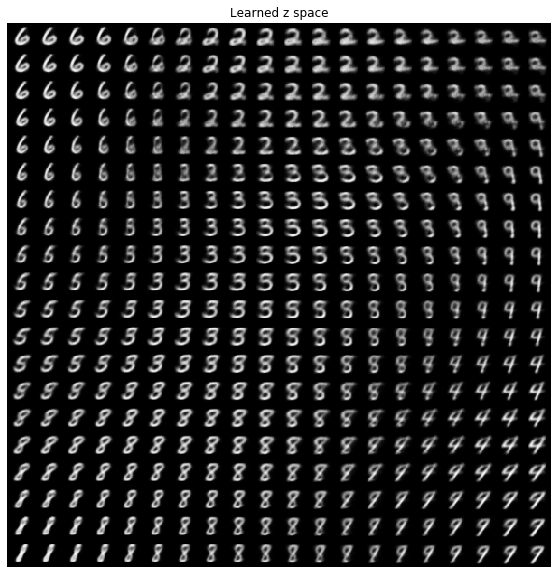

In [27]:
plt.figure(figsize=(10, 10))
z_range = np.arange(-1, 1, 0.1)
z_grid = np.stack(np.meshgrid(z_range, z_range), axis=-1)

z_grid_flat = z_grid.reshape(-1, 2)
x_reconst_flat = vae.decode(torch.tensor(z_grid_flat, dtype=torch.float32, device=device))
x_reconst = x_reconst_flat.detach().cpu().numpy().reshape(-1, *x_shape)

plt.imshow(np.transpose(
    vutils.make_grid(torch.tensor(x_reconst), padding=2, normalize=True, nrow=20).detach().cpu(),(1,2,0)
))
plt.axis('off')
plt.title('Learned z space')